### IDs:
Insert yours IDs to the cell below

ID #1: 324369412

ID #2: 316420132


In [389]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from scipy import stats
import scipy.special
from scipy.stats import ttest_ind, ranksums, kendalltau, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler

In [390]:
# Define file path
csv_path = "AMI_GSE66360_series_matrix.csv"  # Update with the correct path

# Read the CSV file starting from the 60th line
df = pd.read_csv(csv_path, skiprows=59, header=[0,1], encoding='unicode_escape')
labels = pd.read_csv(csv_path, skiprows=58, nrows=1, encoding='unicode_escape').to_numpy()

In [391]:
# Display basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54675 entries, 0 to 54674
Data columns (total 100 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Class, ID_REF)  54675 non-null  object 
 1   (H, GSM1620819)  54674 non-null  float64
 2   (H, GSM1620820)  54674 non-null  float64
 3   (H, GSM1620821)  54675 non-null  float64
 4   (H, GSM1620822)  54674 non-null  float64
 5   (H, GSM1620823)  54674 non-null  float64
 6   (H, GSM1620824)  54675 non-null  float64
 7   (H, GSM1620825)  54674 non-null  float64
 8   (H, GSM1620826)  54675 non-null  float64
 9   (H, GSM1620827)  54674 non-null  float64
 10  (H, GSM1620828)  54674 non-null  float64
 11  (H, GSM1620829)  54673 non-null  float64
 12  (H, GSM1620830)  54674 non-null  float64
 13  (H, GSM1620831)  54673 non-null  float64
 14  (M, GSM1620832)  54674 non-null  float64
 15  (M, GSM1620833)  54675 non-null  float64
 16  (M, GSM1620834)  54675 non-null  float64
 17  (M, GSM1620

In [392]:
# Show the first few rows
print(df.head())

       Class          H                                              \
      ID_REF GSM1620819 GSM1620820 GSM1620821 GSM1620822 GSM1620823   
0  1007_s_at   5.866378   4.948736   5.148384   5.064419   5.017833   
1    1053_at   8.225790   7.525865   7.764637   7.198461   7.831450   
2     117_at   6.179732   6.628137   5.859151   5.974135   6.793079   
3     121_at   6.179478   6.582889   6.602135   6.545905   5.911542   
4  1255_g_at   2.792048   2.695714   2.580181   2.712124   2.723687   

                                               ...          M             \
  GSM1620824 GSM1620825 GSM1620826 GSM1620827  ... GSM1620908 GSM1620909   
0   5.116154   5.431328   5.235271   5.773528  ...   5.419482   5.057716   
1   7.203592   7.694551   7.760259   8.279814  ...   7.226348   7.105538   
2   6.435229   6.320546   6.483590   6.387779  ...   6.789501   7.441940   
3   6.285420   6.562316   6.345888   6.272806  ...   6.513437   6.317523   
4   2.706684   2.674747   2.635150   2.696649 

### QS 3.a.1

In [393]:
# Number of genes (rows)
num_genes = df.shape[0]

print(f"Number of genes profiled: {num_genes}")

Number of genes profiled: 54675


### QS 3.a.2

In [394]:
# Number of samples (columns)
num_samples = df.shape[1]

print(f"Total number of samples: {num_samples}")

Total number of samples: 100


### QS 3.a.3

In [395]:
# Group columns based on prefixes
m_samples = [col for col in df if col[0].startswith('M')]
h_samples = [col for col in df if col[0].startswith('H')]

print(f"Samples in class 'Healthy' (H): {len(h_samples)}")
print(f"Samples in class 'Myocardial Infarction' (M): {len(m_samples)}")

Samples in class 'Healthy' (H): 50
Samples in class 'Myocardial Infarction' (M): 49


### QS 3.a.4

In [396]:
df_cleaned = df.set_index(('Class', 'ID_REF'))

# Remove rows with any NaN values (either from missing values or non-numeric entries)
df_cleaned = df_cleaned.dropna()

# Count remaining genes
num_genes_remaining = df_cleaned.shape[0]

print(f"Number of genes after removing missing, non-numeric, and empty rows: {num_genes_remaining}")

Number of genes after removing missing, non-numeric, and empty rows: 54628


### QS 3.a.5

C:\Users\aferdman\AppData\Local\Temp\ipykernel_16056\1336829739.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(
C:\Users\aferdman\AppData\Local\Temp\ipykernel_16056\1336829739.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(
C:\Users\aferdman\AppData\Local\Temp\ipykernel_16056\1336829739.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(
C:\Users\aferdman\AppData\Local\Temp\ipykernel_16056\1336829739.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will 

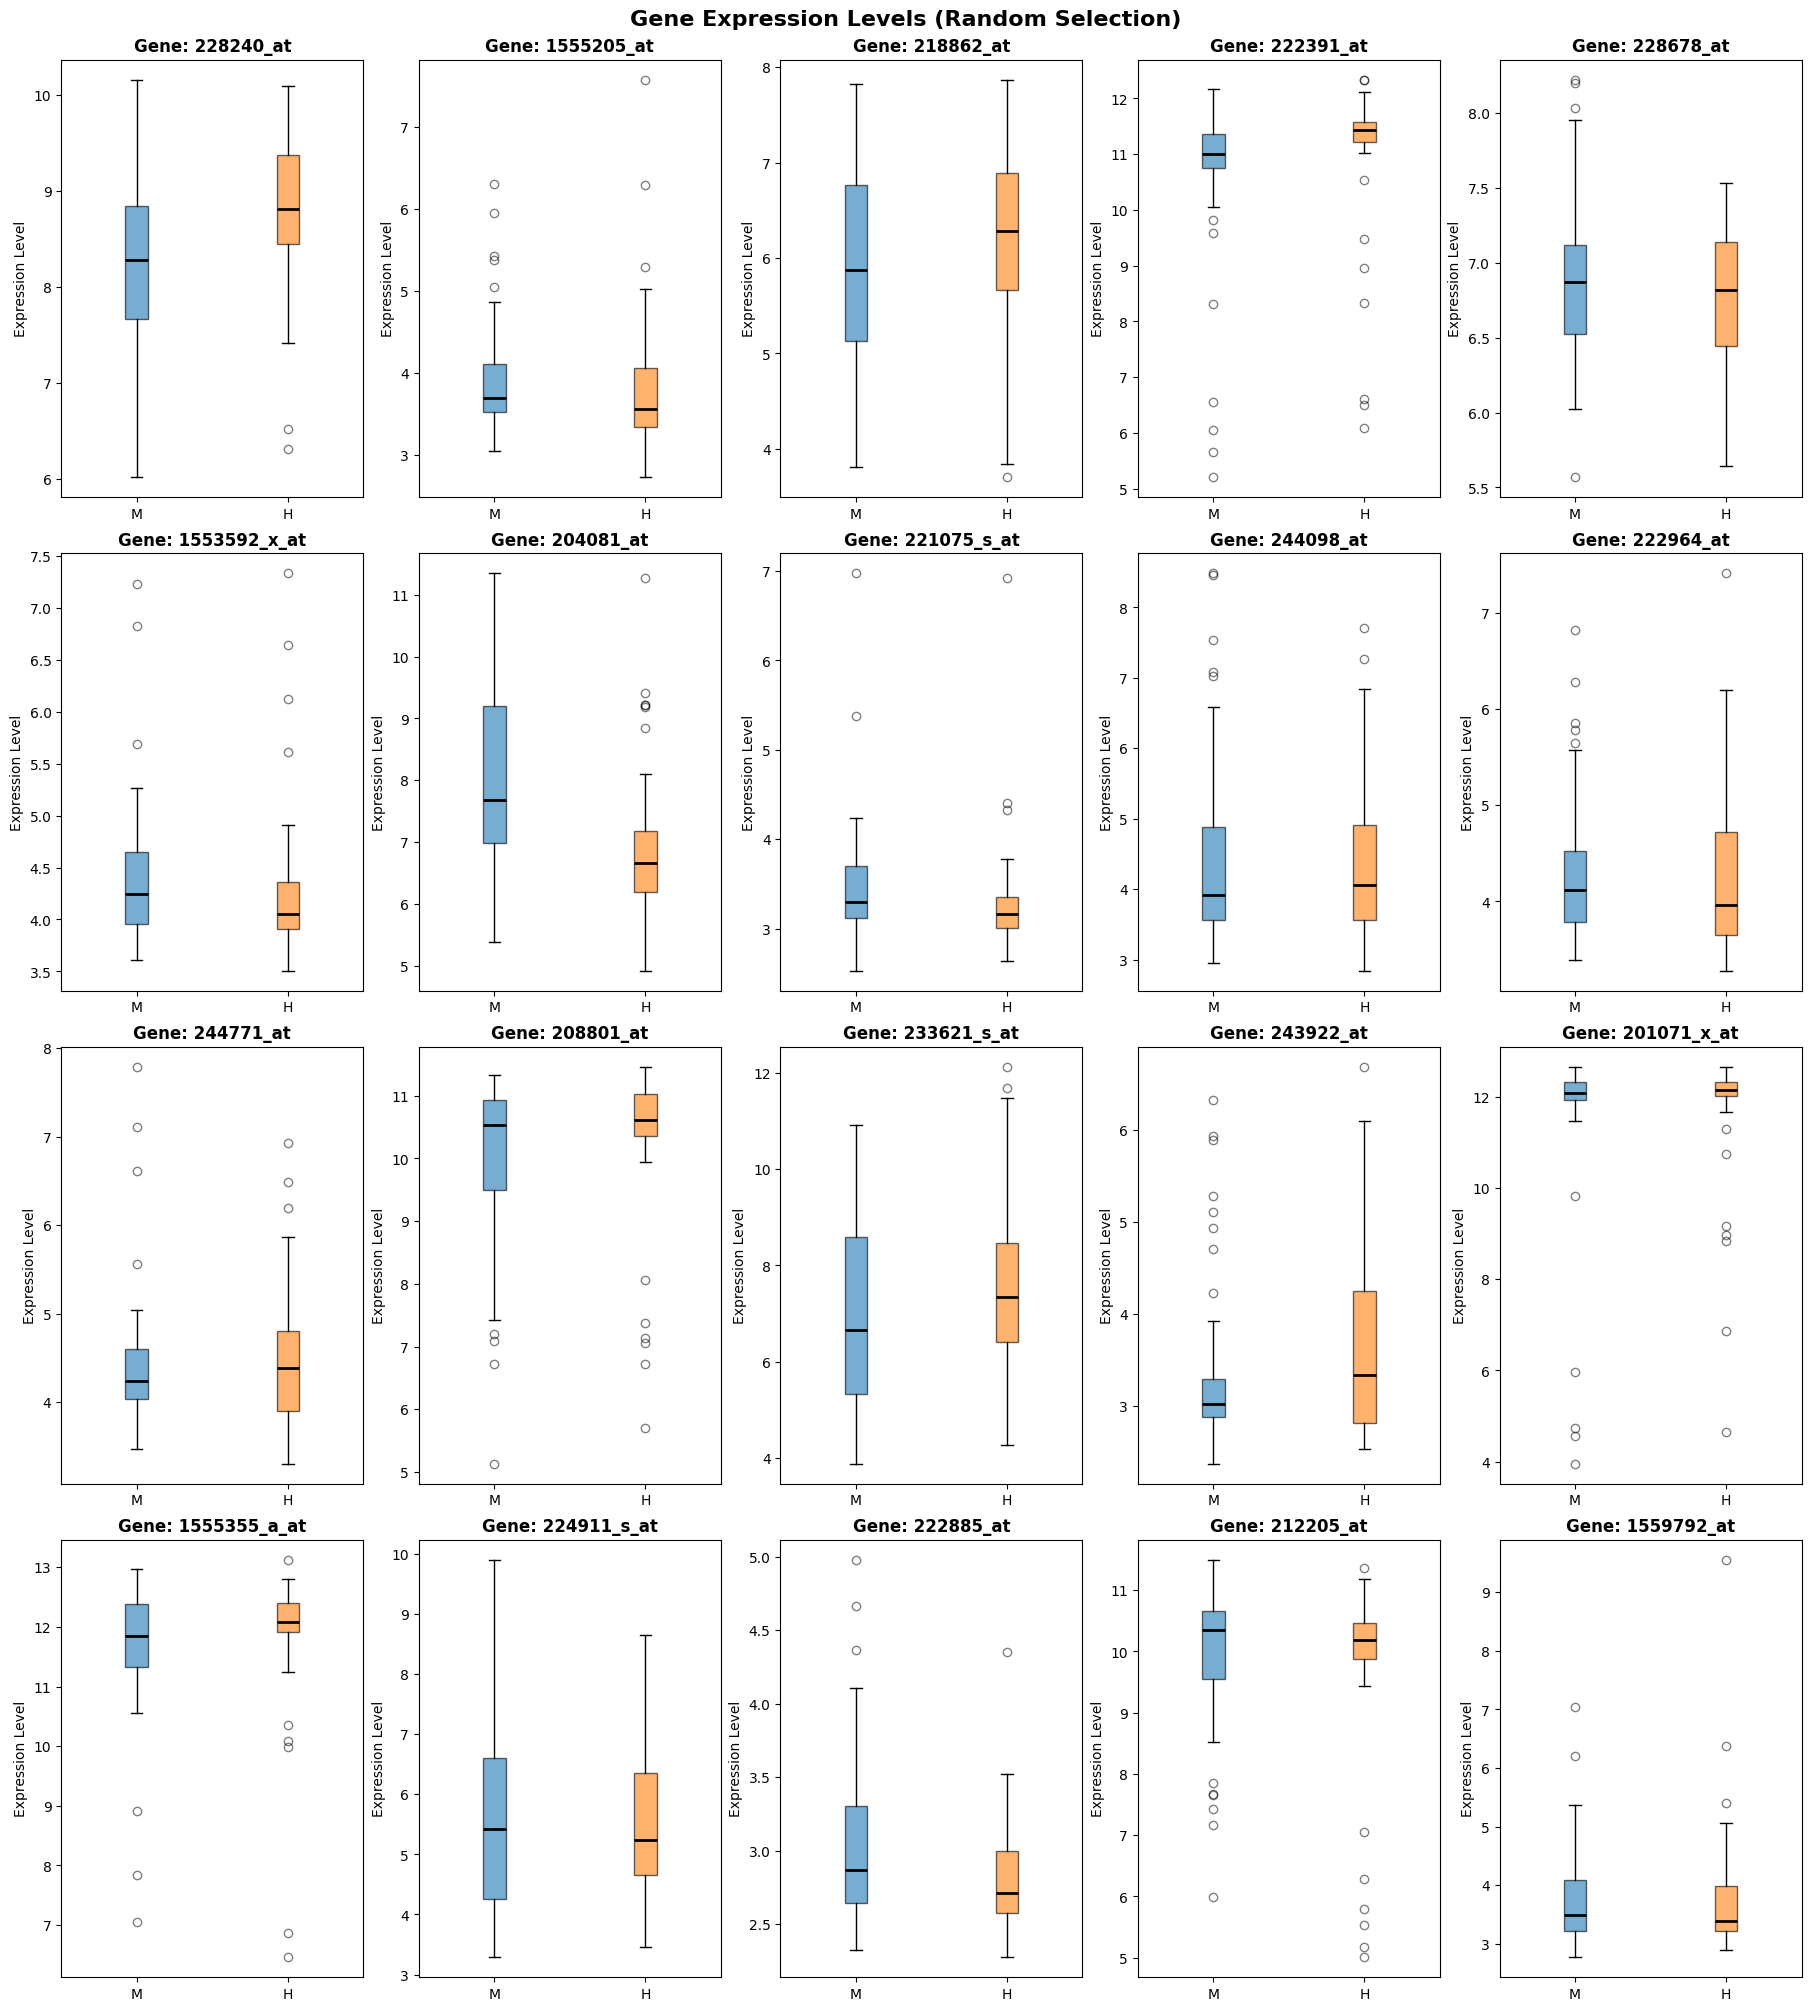

In [397]:
num_of_random_genes = 20

# Select a random subset of genes
random.seed(10)
selected_genes = random.sample(df_cleaned.index.tolist(), num_of_random_genes)

# Adjust figure layout for better readability
fig, axes = plt.subplots(nrows=int(num_of_random_genes / 5), ncols=5, figsize=(18, 20), constrained_layout=True)
axes = axes.flatten()

# Define colors for boxplots
box_colors = ['#1f77b4', '#ff7f0e']  # Blue for M, Orange for H

# Generate boxplots with improved aesthetics
for ax, gene in zip(axes, selected_genes):
    box = ax.boxplot(
        [df_cleaned.loc[gene, m_samples], df_cleaned.loc[gene, h_samples]],
        patch_artist=True,  # Enables color filling
        labels=['M', 'H'],
        medianprops=dict(color='black', linewidth=2),  # Style the median line
        boxprops=dict(facecolor=box_colors[0], alpha=0.6),  # M color
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(marker='o', color='red', alpha=0.5)  # Style outliers
    )
    
    # Apply separate colors for each box
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(f'Gene: {gene}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Expression Level', fontsize=10)

# Add a global title
fig.suptitle('Gene Expression Levels (Random Selection)', fontsize=16, fontweight='bold')

# Save the updated plot
plt.show()


### QS 3.b.1

In [398]:
# Calculate the total number of samples
n_total = len(m_samples) + len(h_samples)

# Calculate the expected sum of ranks for M samples under the null hypothesis
expected_sum_ranks_M = (len(m_samples) * (len(m_samples) + len(h_samples) + 1)) // 2

print(f"Expected sum of ranks for M samples under the null hypothesis: {expected_sum_ranks_M}")

Expected sum of ranks for M samples under the null hypothesis: 2450


### QS 3.b.2

In [399]:
# Calculate the maximal sum of ranks (RS_max) for gene g in the M group
RS_max = (len(m_samples) * (2 * len(h_samples) + len(m_samples) + 1)) // 2

print(f"Maximal sum of ranks for M samples (RS_max): {RS_max}")

Maximal sum of ranks for M samples (RS_max): 3675


### QS 3.b.3

There exists a single, unique order in which all the `m_samples` are ranked the highest, hence:

In [400]:
# Compute binomial coefficient (N choose n_M)
total_combinations = scipy.special.comb(len(m_samples) + len(h_samples), len(m_samples))

# Probability is 1 divided by total combinations
prob_RS_c = 1 / total_combinations

print(prob_RS_c)

1.9823306042837314e-29


### QS 3.b.4

There is only one order in which the sum of `m_samples` equals c-1 (replace the lowest m_sample from being ranked 51 to be ranked 50), hence:

In [401]:
prob_RS_c1 = prob_RS_c

print(prob_RS_c1)

1.9823306042837314e-29


There are 2 possible orders in which the sum of `m_samples` equals c-2, hence:

In [402]:
prob_RS_c2 = 2 / total_combinations

print(prob_RS_c2)

3.964661208567463e-29


### QS 3.b.5

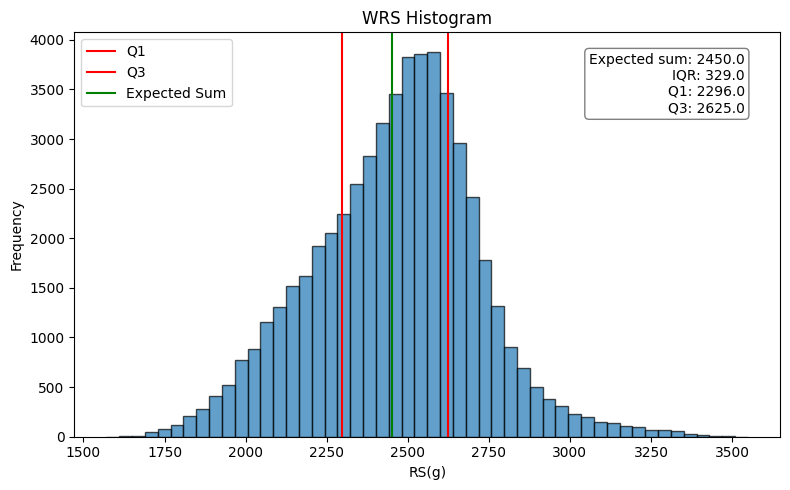

In [403]:
# Function to separate M and H samples from the DataFrame
def split_samples_by_class(df):
    # Identify M and H columns by checking their prefix
    m_columns = [col for col in df.columns if col[0] == 'M' and col != ('Class', 'ID_REF')]
    h_columns = [col for col in df.columns if col[0] == 'H' and col != ('Class', 'ID_REF')]
    
    return m_columns, h_columns


# Compute WRS statistic for differential expression
def calculate_rank_sum_for_m_samples(df):
    # Separate the M and H columns
    m_columns, h_columns = split_samples_by_class(df)
    
    wrs_rank_sums = []  # Initialize an empty list to store the rank sums
    
    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        m_values = row[m_columns].astype(float)  # Get M values for the row as floats
        h_values = row[h_columns].astype(float)  # Get H values for the row as floats
        
        # Combine M and H values and calculate their ranks
        combined_values = np.concatenate([m_values, h_values])
        combined_ranks = stats.rankdata(combined_values)  # Get ranks for all values
        
        # Sum ranks corresponding to the M columns only
        m_rank_sum = np.sum(combined_ranks[:len(m_columns)])  # Only sum the M ranks
        
        wrs_rank_sums.append(m_rank_sum)  # Append the calculated rank sum for the row
    
    return np.array(wrs_rank_sums)  # Return the rank sums as a numpy array

# Compute WRS statistics
wrs_stats = calculate_rank_sum_for_m_samples(df)

# Compute expected sum
expected_sum = len(m_samples) * (len(m_samples) + len(h_samples) + 1) / 2

# Compute percentiles using scipy
q1 = np.nanpercentile(wrs_stats, 25)
q3 = np.nanpercentile(wrs_stats, 75)
iqr = q3 - q1

# Create a new figure
plt.figure(figsize=(8, 5))

# Plot histogram
plt.hist(wrs_stats, bins=50, edgecolor='black', alpha=0.7)

# Add vertical lines
plt.axvline(x=q1, color='r', label='Q1')
plt.axvline(x=q3, color='r', label='Q3')
plt.axvline(x=expected_sum, color='green', linestyle='-', label='Expected Sum')

plt.title('WRS Histogram')
plt.xlabel('RS(g)')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Annotate with statistics
plt.annotate(f'Expected sum: {expected_sum}\nIQR: {iqr}\nQ1: {q1}\nQ3: {q3}', 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()

# Display the plot in the notebook
plt.show()


### QS 3.c

In [404]:
def compare_gene_expression(df):
    # Ensure MultiIndex columns are accessible
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col) for col in df.columns]
    
    # Split H and M groups
    h_cols = [col for col in df.columns if col.startswith('H_')]
    m_cols = [col for col in df.columns if col.startswith('M_')]
    
    # Compute one-sided tests
    results = []
    for gene in df.index:
        h_values = df.loc[gene, h_cols].dropna()
        m_values = df.loc[gene, m_cols].dropna()
        
        if len(h_values) > 1 and len(m_values) > 1:
            # Student's t-test
            t_stat_greater, p_t_greater = stats.ttest_ind(m_values, h_values, alternative='greater', nan_policy='omit')
            t_stat_less, p_t_less = stats.ttest_ind(m_values, h_values, alternative='less', nan_policy='omit')
            
            # Wilcoxon Rank-Sum Test (WRS)
            wrs_stat_greater, p_wrs_greater = stats.ranksums(m_values, h_values, alternative='greater')
            wrs_stat_less, p_wrs_less = stats.ranksums(m_values, h_values, alternative='less')
            
            results.append([gene, p_t_greater, p_t_less, p_wrs_greater, p_wrs_less])
    
    # Create DataFrame
    results_df = pd.DataFrame(results, columns=['Gene', 'p_t_greater', 'p_t_less', 'p_wrs_greater', 'p_wrs_less'])
    
    # Filter significant genes at p <= 0.07
    t_overexpressed_m = results_df[results_df['p_t_greater'] <= 0.07]
    t_underexpressed_m = results_df[results_df['p_t_less'] <= 0.07]
    wrs_overexpressed_m = results_df[results_df['p_wrs_greater'] <= 0.07]
    wrs_underexpressed_m = results_df[results_df['p_wrs_less'] <= 0.07]

    return results_df, wrs_overexpressed_m, wrs_underexpressed_m, t_overexpressed_m, t_underexpressed_m

# Example call
gene_expression_df, wrs_overexpressed_m, wrs_underexpressed_m, t_overexpressed_m, t_underexpressed_m = compare_gene_expression(df_cleaned)

In [405]:
# Print summary
print("\nGene Expression Analysis Summary:")
print(f"Total genes analyzed: {len(gene_expression_df)}")

print("\nT-test Results:")
print(f"Genes overexpressed in M: {len(t_overexpressed_m)}")
print(f"Genes underexpressed in M: {len(t_underexpressed_m)}")

print("\nWilcoxon Rank Sum Test Results:")
print(f"Genes overexpressed in M: {len(wrs_overexpressed_m)}")
print(f"Genes underexpressed in M: {len(wrs_underexpressed_m)}")



Gene Expression Analysis Summary:
Total genes analyzed: 54628

T-test Results:
Genes overexpressed in M: 8517
Genes underexpressed in M: 8639

Wilcoxon Rank Sum Test Results:
Genes overexpressed in M: 10787
Genes underexpressed in M: 10667


### QS 3.d.1

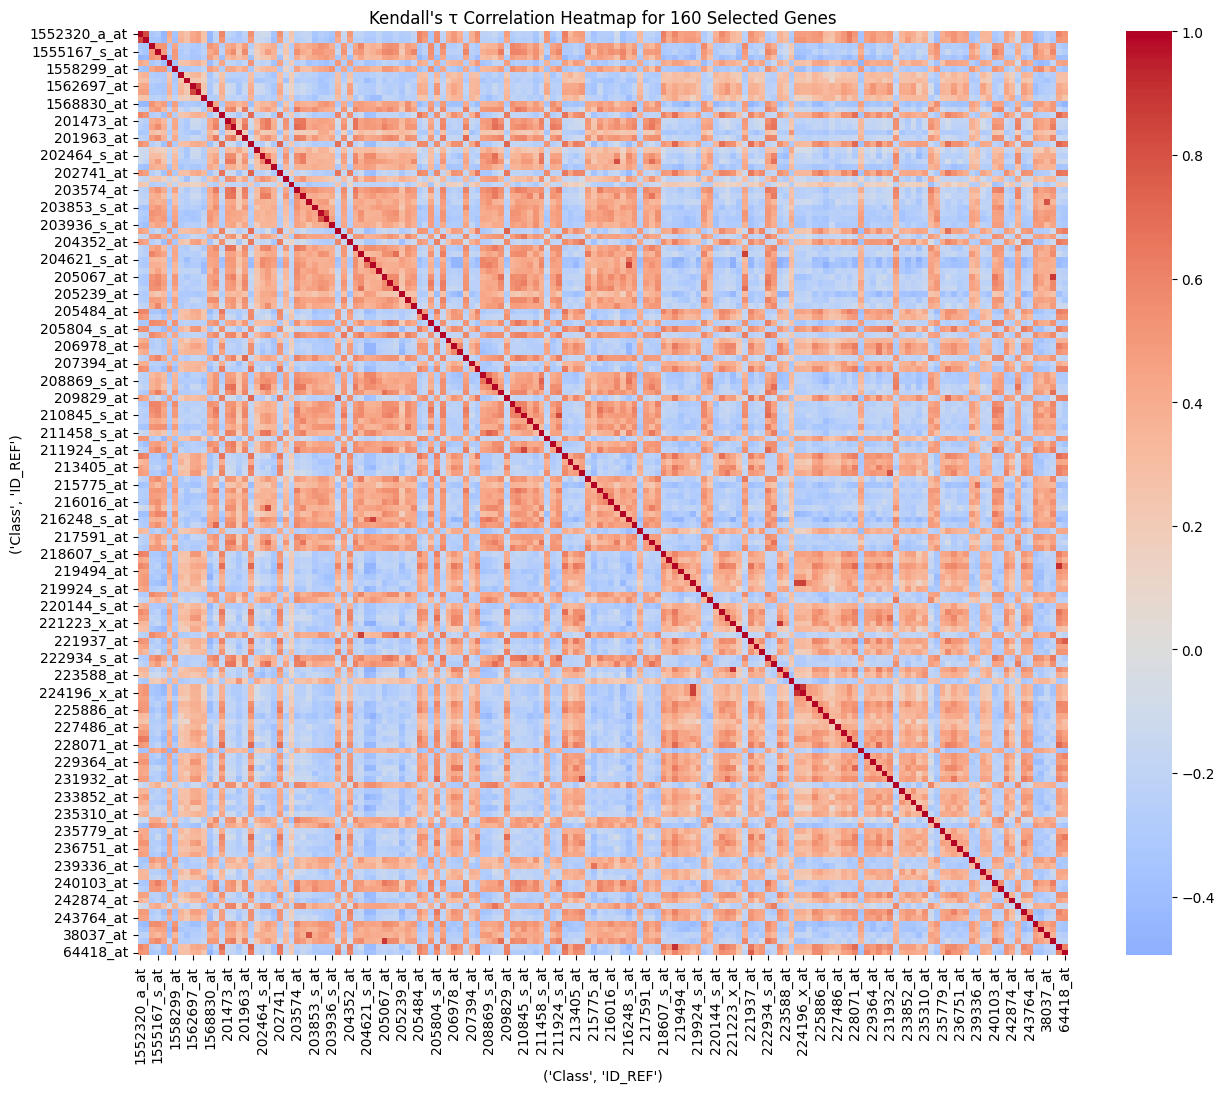

In [406]:
def compute_kendall_correlation(df, wrs_overexpressed_m, wrs_underexpressed_m):
    """Computes Kendall correlation for the top 80 significant over- and under-expressed genes."""
    
    # Select the top 80 significant genes based on p-value
    top_overexpressed = wrs_overexpressed_m.nsmallest(80, 'p_wrs_greater')
    top_underexpressed = wrs_underexpressed_m.nsmallest(80, 'p_wrs_less')

    # Create the set of 160 unique genes
    selected_genes = pd.concat([top_overexpressed, top_underexpressed]).drop_duplicates(subset=['Gene'])
    
    # Extract gene names and their corresponding expression data
    gene_names = selected_genes['Gene'].tolist()
    
    # Filter the main df for only the selected genes
    selected_expression_data = df[df[('Class', 'ID_REF')].isin(gene_names)].set_index(('Class', 'ID_REF'))
    
    # Compute Kendall's tau correlation matrix
    correlation_matrix = selected_expression_data.T.corr(method='kendall')

    return correlation_matrix

def plot_correlation_heatmap(correlation_matrix):
    """Plots the heatmap of the Kendall correlation matrix."""
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
    plt.title("Kendall's τ Correlation Heatmap for 160 Selected Genes")
    plt.show()

# Compute Kendall correlation matrix
kendall_correlation_matrix = compute_kendall_correlation(df, wrs_overexpressed_m, wrs_underexpressed_m)

# Plot heatmap
plot_correlation_heatmap(kendall_correlation_matrix)


### QS 3.d.2

### Expected Value of Kendall’s τ Under the Null Model  

Under the null hypothesis of independence, the rankings of two genes are randomly related. Since concordant and discordant pairs are equally likely, the expected value of Kendall’s τ is **0**, meaning no correlation. Any deviation from 0 suggests a non-random relationship between gene expressions.  

### QS 3.d.3

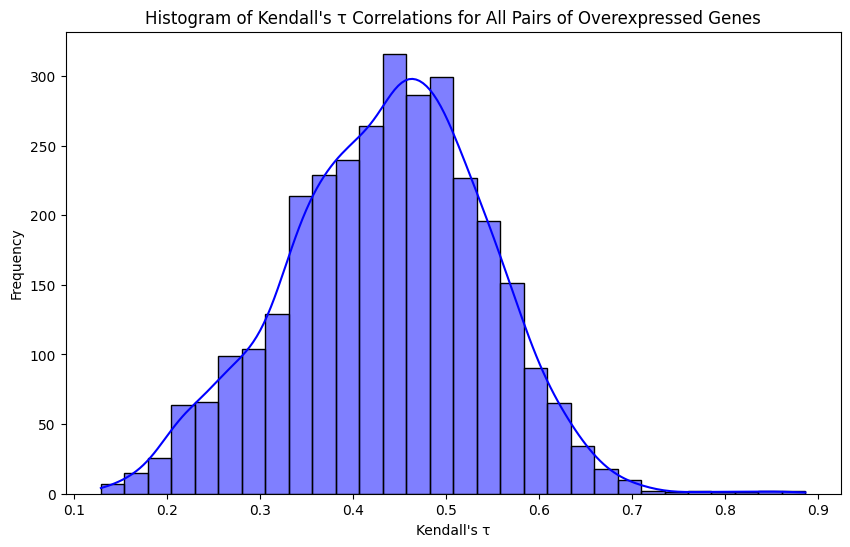

Average Kendall's τ value: 0.4363


In [407]:
def compute_kendall_pairs_correlation(df, wrs_overexpressed_m):
    """Computes Kendall correlation for all 80 choose 2 pairs of overexpressed genes."""
    
    # Select the top 80 overexpressed genes based on p-value (already filtered in wrs_overexpressed_m)
    top_overexpressed = wrs_overexpressed_m.nsmallest(80, 'p_wrs_greater')

    # Get the gene names of the top 80 overexpressed genes
    overexpressed_genes = top_overexpressed['Gene'].tolist()

    # Filter the main df for only the overexpressed genes
    overexpressed_data = df[df[('Class', 'ID_REF')].isin(overexpressed_genes)].set_index(('Class', 'ID_REF'))

    # Initialize a list to store the correlation values
    correlation_values = []

    # Compute Kendall's Tau correlation for each pair of overexpressed genes
    for i in range(len(overexpressed_genes)):
        for j in range(i+1, len(overexpressed_genes)):
            gene1 = overexpressed_genes[i]
            gene2 = overexpressed_genes[j]
            
            # Extract the expression data for the two genes
            gene1_data = overexpressed_data.loc[gene1].values
            gene2_data = overexpressed_data.loc[gene2].values
            
            # Compute Kendall's Tau for the two genes
            tau, _ = kendalltau(gene1_data, gene2_data)
            
            # Append the result to the list
            correlation_values.append(tau)

    return correlation_values

def plot_histogram(correlation_values):
    """Plots a histogram of the Kendall correlation values."""
    plt.figure(figsize=(10, 6))
    sns.histplot(correlation_values, kde=True, bins=30, color='blue')
    plt.title("Histogram of Kendall's τ Correlations for All Pairs of Overexpressed Genes")
    plt.xlabel("Kendall's τ")
    plt.ylabel("Frequency")
    plt.show()

# Compute the Kendall 𝜏 correlations for all pairs
kendall_correlation_values = compute_kendall_pairs_correlation(df.dropna(), wrs_overexpressed_m)

# Plot the histogram of Kendall's τ values
plot_histogram(kendall_correlation_values)

# Compute the average Kendall's τ value
average_tau = np.mean(kendall_correlation_values)
print(f"Average Kendall's τ value: {average_tau:.4f}")

The average Kendall's τ value for the 80 overexpressed gene pairs is 0.4363, showing a moderate positive correlation. This suggests some similarity in gene expression, but there are still differences.

### QS 3.d.4

Co-expression analysis in D shows that some genes have similar expression patterns, suggesting possible regulatory relationships. The average Kendall's τ of 0.4363 indicates a moderate positive correlation, meaning there is some similarity in gene expression, but also differences. This highlights potential gene networks and regulatory mechanisms.

### QS 3.d.5

The total number of gene pairs in the dataset is calculated using the combination formula ${54628 \choose 2}$, which gives approximately **1.5 billion** possible gene pairs. 

At an FDR of 0.05, the Benjamini-Hochberg procedure controls the proportion of false positives among the significant results. This means we expect **5%** of the gene pairs to be false positives. Therefore, applying the FDR threshold to the entire dataset, we would expect around **74.7 million** significant co-expressed gene pairs (0.05 * 1,494,350,778).

This helps control false positives and highlights the most reliable gene relationships. The moderate correlation observed in the top 80 genes suggests that many of these pairs likely share biologically meaningful co-expression patterns.


### QS 3.d.6

Computing co-expression for all genes gives a broader view of gene interactions, potentially uncovering new pathways and networks. However, it introduces more noise from less significant genes, increases computational demands, and raises the risk of false positives. Focusing on the most significant genes, as in set D, helps reduce these issues, making the analysis more focused and reliable.

### QS 3.e.1

In [408]:
def extract_gene_expression(row, m_columns, h_columns):
    """Extracts gene expression data for M and H samples."""
    return row[('Class', 'ID_REF')], row[m_columns].astype(float).dropna(), row[h_columns].astype(float).dropna()

def create_gene_expression_df(df):
    """Performs differential gene expression analysis using t-test and Wilcoxon rank-sum test."""
    m_columns, h_columns = split_samples_by_class(df)
    results = []

    for _, row in df.iterrows():
        gene_name, m_data, h_data = extract_gene_expression(row, m_columns, h_columns)

        # Perform statistical tests
        t_stat, t_pvalue = stats.ttest_ind(m_data, h_data, equal_var=False, nan_policy='omit')
        wrs_stat, wrs_pvalue = stats.ranksums(m_data, h_data)

        results.append({
            'Gene': gene_name,
            't_stat': t_stat,
            't_pvalue': t_pvalue,
            'wrs_stat': wrs_stat,
            'wrs_pvalue': wrs_pvalue
        })

    # Convert results to DataFrame
    return pd.DataFrame(results)


Threshold τ = 0.05:
Significant genes (T-test): 5787
Significant genes (WRS): 7576
Expected overexpressed genes: 2731.40

Threshold τ = 0.01:
Significant genes (T-test): 2288
Significant genes (WRS): 2832
Expected overexpressed genes: 546.28

Threshold τ = 0.005:
Significant genes (T-test): 1799
Significant genes (WRS): 2135
Expected overexpressed genes: 273.14


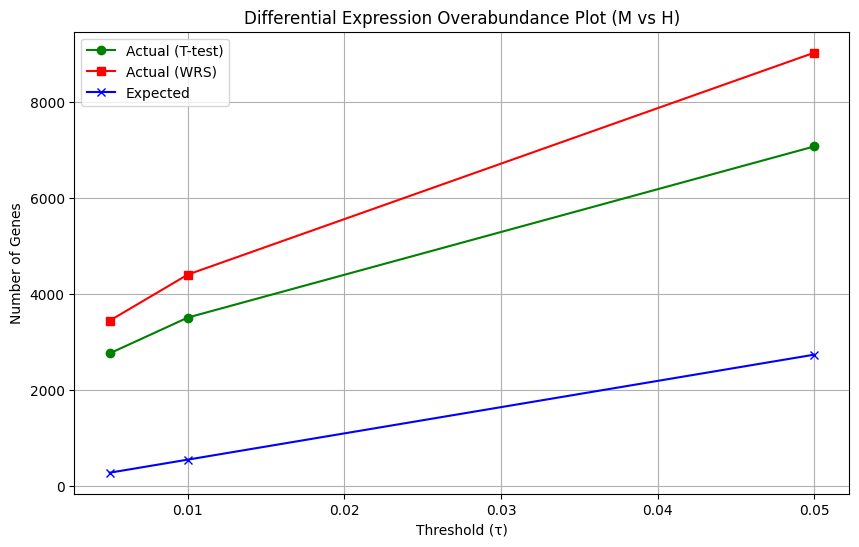

In [409]:
# Function to calculate expected values
def calculate_expected_values(p_val_thresholds, num_genes):
    return {tau: num_genes * tau for tau in p_val_thresholds}

# Function to count significant genes below a given p-value threshold
def count_significant_genes(df, pval_col, thresholds):
    return [len(df[df[pval_col] < tau]) for tau in thresholds]

# Function to calculate expected values
def calculate_expected_values(p_val_thresholds, num_genes):
    return {tau: num_genes * tau for tau in p_val_thresholds}

# Function to compute FDR adjusted p-values using Benjamini-Hochberg procedure
def compute_fdr_for_genes(p_values):
    # Sort p-values in ascending order
    sorted_pvals = np.sort(p_values)
    n = len(sorted_pvals)
    
    # Compute FDR adjusted p-values
    fdr_values = sorted_pvals * n / (np.arange(1, n+1))
    
    # Ensure FDR is non-decreasing by taking the minimum between current FDR and previous FDR
    fdr_values = np.minimum.accumulate(fdr_values[::-1])[::-1]
    
    # Map FDR values back to the original p-value indices
    original_indices = np.argsort(p_values)
    fdr_adjusted_pvals = np.zeros_like(p_values)
    fdr_adjusted_pvals[original_indices] = fdr_values
    
    return fdr_adjusted_pvals

# Function to count significant genes below a given FDR threshold
def count_significant_genes_by_fdr(fdr_values, thresholds):
    significant_genes = {}
    for tau in thresholds:
        significant_genes[tau] = np.sum(fdr_values < tau)
    return significant_genes

# Function to plot actual vs expected TNoM scores
def plot_de_overabundance(actual_counts_t, actual_counts_wrs, expected_counts, p_val_thresholds):
    plt.figure(figsize=(10, 6))

    # Plot T-test actual values (green)
    plt.plot(p_val_thresholds, actual_counts_t, color='green', label="Actual (T-test)", marker='o')

    # Plot WRS actual values (red)
    plt.plot(p_val_thresholds, actual_counts_wrs, color='red', label="Actual (WRS)", marker='s')

    # Plot Expected values (blue)
    plt.plot(p_val_thresholds, expected_counts, color='blue', label="Expected", marker='x')

    # Labels and title
    plt.xlabel('Threshold (τ)')
    plt.ylabel('Number of Genes')
    plt.title('Differential Expression Overabundance Plot (M vs H)')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

# Set p-value thresholds and number of genes (length of your DataFrame)
p_val_thresholds = [0.05, 0.01, 0.005]
num_genes = len(gene_expression_df)  # Total number of genes

# Calculate expected values
expected_values = calculate_expected_values(p_val_thresholds, num_genes)
expected_counts = list(expected_values.values())  # Convert dictionary to list for plotting

# Calculate actual significant gene counts for T-test and WRS (using FDR threshold)
actual_counts_t = count_significant_genes(t_overexpressed_m, 'p_t_greater', p_val_thresholds)
actual_counts_wrs = count_significant_genes(wrs_overexpressed_m, 'p_wrs_greater', p_val_thresholds)

# Apply FDR computation to the T-test and WRS p-values for each sample (assuming you have these p-values from your results)
t_test_p_values = t_overexpressed_m['p_t_greater'].values
wrs_p_values = wrs_overexpressed_m['p_wrs_greater'].values

# Compute FDR values for both T-test and WRS for each gene
fdr_t = compute_fdr_for_genes(t_test_p_values)
fdr_wrs = compute_fdr_for_genes(wrs_p_values)

# Count the significant genes by FDR thresholds for T-test and WRS
significant_genes_t = count_significant_genes_by_fdr(fdr_t, p_val_thresholds)
significant_genes_wrs = count_significant_genes_by_fdr(fdr_wrs, p_val_thresholds)

# Reporting the number of significant genes with FDR thresholds
for tau in p_val_thresholds:
    print(f"\nThreshold τ = {tau}:")
    print(f"Significant genes (T-test): {significant_genes_t[tau]}")
    print(f"Significant genes (WRS): {significant_genes_wrs[tau]}")
    print(f"Expected overexpressed genes: {expected_counts[p_val_thresholds.index(tau)]:.2f}")

# Plot the DE overabundance plot
plot_de_overabundance(actual_counts_t, actual_counts_wrs, expected_counts, p_val_thresholds)


### QS 3.e.2.a

In [410]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Function to calculate WRS p-value for a gene after label flip
def calculate_wrs_p_value(group_H, group_M):
    _, p_value = mannwhitneyu(group_H, group_M, alternative='less')
    return p_value

# Initialize a dictionary to store the p_U(g) values for each gene
p_U_values = {}

# Iterate over each gene (rows in your dataframe)
for gene in df_cleaned.index:
    p_values = []
    
    # Get the expression values for the current gene across all samples
    gene_expression_values = df_cleaned.loc[gene].values

    # Split data into "H" and "M" groups based on MultiIndex
    H_group = gene_expression_values[df_cleaned.columns.str.startswith('H')]
    M_group = gene_expression_values[df_cleaned.columns.str.startswith('M')]

    # Ensure we have samples for both groups
    if len(H_group) == 0 or len(M_group) == 0:
        continue  # Skip if one of the groups is empty
    
    # Number of samples in each group
    num_H = len(H_group)
    num_M = len(M_group)
    
    # Perform label swaps: move one sample from H -> M and vice versa
    for i in range(num_H):
        swapped_H_group = np.copy(H_group)
        swapped_M_group = np.copy(M_group)
        # Append the i-th sample from H to M
        swapped_M_group = np.append(swapped_M_group, H_group[i])
        # Remove the i-th sample from H
        swapped_H_group = np.delete(swapped_H_group, i)

        # Compute p-value after the swap
        p_value = calculate_wrs_p_value(swapped_H_group, swapped_M_group)
        p_values.append(p_value)

    for i in range(num_M):
        swapped_H_group = np.copy(H_group)
        swapped_M_group = np.copy(M_group)
        # Append the i-th sample from M to H (fixing the mistake)
        swapped_H_group = np.append(swapped_H_group, M_group[i])
        # Remove the i-th sample from M
        swapped_M_group = np.delete(swapped_M_group, i)

        # Compute p-value after the swap
        p_value = calculate_wrs_p_value(swapped_H_group, swapped_M_group)
        p_values.append(p_value)
    
    # Store the maximum p-value for the gene
    p_U_values[gene] = max(p_values)

# Convert the p_U values dictionary to a pandas Series for easy viewing
p_U_series = pd.Series(p_U_values)

# Now p_U_series contains the maximum p-value for each gene (p_U(g))
print(p_U_series)


KeyboardInterrupt: 

### QS 3.e.2.b

In [ ]:
# Step 1: Sort the p-values (ascending order)
sorted_p_values = p_U_series.sort_values()

# Step 2: Compute the adjusted p-values using the Benjamini-Hochberg procedure
N = len(sorted_p_values)  # Total number of genes
adjusted_p_values = sorted_p_values * N / (np.arange(1, N + 1))

# Step 3: Apply the threshold tau = 0.05
tau = 0.05
significant_genes = adjusted_p_values[adjusted_p_values <= tau]

# How many genes can we report now?
num_significant_genes = len(significant_genes)
print(f"Number of genes with significant p-values after FDR correction: {num_significant_genes}")


Number of genes with significant p-values after FDR correction: 1842


### QS 3.e.2.c

In [ ]:
# Assuming tau is the threshold value, e.g., tau = 0.05
tau = 0.05

# From section 3e1a
t_overexpressed_genes = t_overexpressed_m[t_overexpressed_m['p_t_greater'] < tau]['Gene']
t_underexpressed_genes = t_underexpressed_m[t_underexpressed_m['p_t_less'] < tau]['Gene']
wrs_overexpressed_genes = wrs_overexpressed_m[wrs_overexpressed_m['p_wrs_greater'] < tau]['Gene']
wrs_underexpressed_genes = wrs_underexpressed_m[wrs_underexpressed_m['p_wrs_less'] < tau]['Gene']

all_original_significant_genes = set(wrs_overexpressed_genes).union(set(wrs_underexpressed_genes))

# uncomment if the t-test results also required
# all_original_significant_genes = set(t_overexpressed_genes).union(set(t_underexpressed_genes),
#                                                         set(wrs_overexpressed_genes), 
#                                                         set(wrs_underexpressed_genes))

# Intersect with the significant_genes (list of gene names)
intersection_genes = all_original_significant_genes.intersection(set(significant_genes.keys()))

# Output the intersected genes
print(f"Number of intersected genes: {len(intersection_genes)}")
print(f"Intersected Genes: {intersection_genes}")


Number of intersected genes: 1842
Intersected Genes: {'1552670_a_at', '213805_at', '208092_s_at', '224327_s_at', '223767_at', '1554014_at', '1558920_at', '1553134_s_at', '243638_at', '37028_at', '202082_s_at', '229865_at', '203505_at', '208248_x_at', '235479_at', '211067_s_at', '1563118_at', '211527_x_at', '244395_at', '221958_s_at', '223660_at', '200920_s_at', '202917_s_at', '214788_x_at', '227680_at', '226982_at', '203066_at', '212670_at', '209696_at', '1552798_a_at', '203752_s_at', '237255_at', '242335_at', '213418_at', '225282_at', '238560_at', '209304_x_at', '234644_x_at', '205312_at', '219228_at', '214983_at', '202130_at', '236982_at', '206036_s_at', '1562255_at', '1562878_at', '210314_x_at', '237618_at', '226430_at', '210452_x_at', '201566_x_at', '203140_at', '205863_at', '228263_at', '204183_s_at', '1554114_s_at', '1553297_a_at', '214445_at', '220532_s_at', '210222_s_at', '216260_at', '240358_at', '208416_s_at', '1559909_a_at', '223204_at', '1558845_at', '242958_x_at', '218611_

### QS 3.e.3

In [ ]:
def plot_heatmap(df_filtered):
    # Normalize the data using z-score normalization
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), columns=df_filtered.columns, index=df_filtered.index)

    # Separate columns based on the sample labels containing 'M' or 'H'
    H_samples = df_scaled.columns[df_scaled.columns.str.startswith('H_')]
    M_samples = df_scaled.columns[df_scaled.columns.str.startswith('M_')]

    # Reorder the columns: first the M samples, then the H samples
    ordered_columns = M_samples.append(H_samples)

    # Reorder the dataframe based on the new column order
    df_ordered = df_scaled[ordered_columns]

    # Plot the heatmap with reordered columns and no labels
    plt.figure(figsize=(13, 10))  # Set the figure size
    sns.heatmap(df_ordered, cmap='coolwarm', cbar_kws={'label': 'Expression level'}, 
                xticklabels=False, yticklabels=False, cbar=True)

    # Add a vertical line between M and H samples
    plt.axvline(x=len(M_samples)-0.5, color='k', linewidth=2, linestyle='--')

    # Title and labels for clarity
    plt.title('Heatmap of Significant Gene Expression')
    plt.xlabel('Samples')
    plt.ylabel('Genes')

    plt.show()

In [ ]:
top_samples = 3

# Assuming D is the union of top_overexpressed and top_underexpressed
top_overexpressed_genes = wrs_overexpressed_m.nsmallest(top_samples, 'p_wrs_greater')['Gene']
top_underexpressed_genes = wrs_underexpressed_m.nsmallest(top_samples, 'p_wrs_less')['Gene']
D = pd.concat([top_overexpressed_genes, top_underexpressed_genes]).drop_duplicates()

# Select any 3 genes from D (manually or randomly)
selected_genes = D.sample(3, random_state=42).tolist()

selected_genes

['208869_s_at', '216248_s_at', '206978_at']

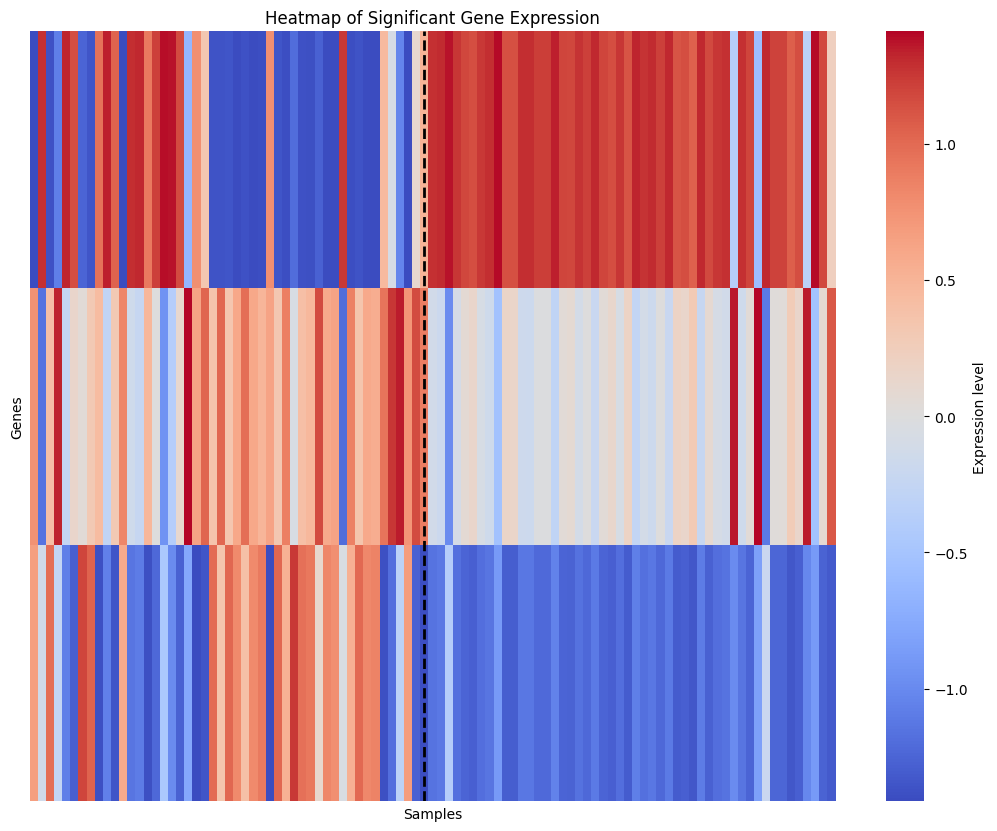

In [ ]:
df_filtered = df_cleaned.loc[df_cleaned.index.isin(selected_genes)]
plot_heatmap(df_filtered)


### QS 3.e.4

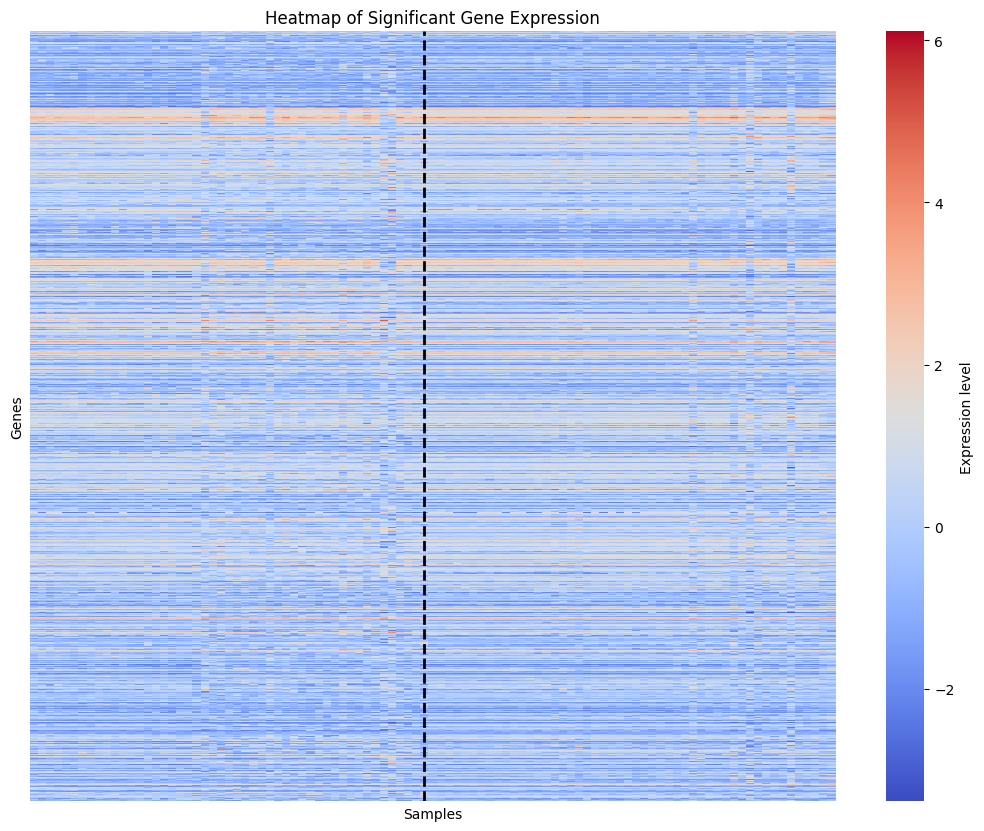

In [ ]:
tau = 0.005

t_overexpressed_genes = t_overexpressed_m[t_overexpressed_m['p_t_greater'] < tau]['Gene']
t_underexpressed_genes = t_underexpressed_m[t_underexpressed_m['p_t_less'] < tau]['Gene']
wrs_overexpressed_genes = wrs_overexpressed_m[wrs_overexpressed_m['p_wrs_greater'] < tau]['Gene']
wrs_underexpressed_genes = wrs_underexpressed_m[wrs_underexpressed_m['p_wrs_less'] < tau]['Gene']

all_original_significant_genes = set(wrs_overexpressed_genes).union(set(wrs_underexpressed_genes))

df_filtered = df_cleaned.loc[df_cleaned.index.isin(all_original_significant_genes)]
plot_heatmap(df_filtered)

